In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit import Aer
from squlearn import Executor
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam
from squlearn import Executor
from squlearn import Executor
from squlearn.encoding_circuit import HubregtsenEncodingCircuit
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.ml import QGPR

from qiskit.circuit.library import TwoLocal
from squlearn.encoding_circuit import *

algorithm_globals.random_seed = 42



In [2]:

# Function to read and process data from the input format
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    features = []
    labels = []

    i = 0
    while i < 2000:
        num_atoms = int(lines[i])
        energy = float(lines[i + 1].split()[-1])
        label = np.array([energy])

        atom_data = [line.split() for line in lines[i + 2:i + 2 + num_atoms]]
        coordinates = np.array([[float(coord) for coord in atom[1:]] for atom in atom_data])

        features.append(coordinates.flatten())
        labels.append(label)

        i += 2 + num_atoms

    return np.array(features), np.array(labels)


# Read data from the provided file
file_path = 'water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz'
features, labels = read_data(file_path)
print(features[:3], labels[:3])
print(len(features), len(labels))

[[ 0.0089378   0.          0.43550962 -0.79730093  0.         -0.59766049
   0.6554516   0.         -0.48758562]
 [ 0.00715024  0.          0.43550962 -0.78311599  0.         -0.586653
   0.66963653  0.         -0.49859311]
 [-0.02323827  0.          0.43812567 -0.57271362  0.         -0.42028506
   0.94152185  0.         -0.70647973]] [[-76.27315556]
 [-76.27389312]
 [-76.2506881 ]]
400 400


In [3]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

features = MinMaxScaler().fit_transform(features)

train_labelm = np.mean(labels)
train_labelstd = np.std(labels)

print("Mean = ", train_labelm, "Std =", train_labelstd)

transformed_labels = (labels - train_labelm) / train_labelstd
print(len(transformed_labels))
print(transformed_labels[1])
print(features[1])

test_size=0.2
train_features, test_features, train_labels, test_labels = train_test_split(
    features, transformed_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


Mean =  -76.1244452830175 Std = 0.09935006498137963
400
[-1.50425506]
[0.625      0.         0.88480711 0.18156391 0.         0.25814234
 0.68614404 0.         0.44156504]


In [4]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [5]:
enc_circ = HubregtsenEncodingCircuit(num_qubits=3, num_features=9, num_layers=3)
q_kernel = FidelityKernel(encoding_circuit=enc_circ, executor=Executor("statevector_simulator"))
q_kernel.assign_parameters(np.random.rand(enc_circ.num_parameters))
qgpr_ansatz = QGPR(quantum_kernel=q_kernel)
qgpr_ansatz.fit(train_features, train_labels)

QGPR(quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x00000217E39A2610>)

In [6]:
predictions = qgpr_ansatz.predict(test_features)


RMSE: 0.0019813491525306056
MSE: 0.03904260021372414
R-squared (R2) Score: 0.9996625073692442


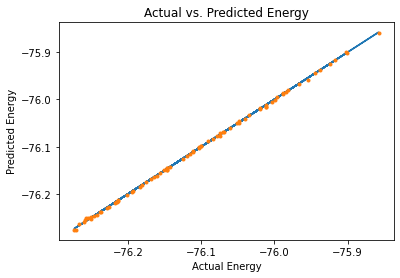

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Inverse transform the transformed labels
predictions = (predictions * train_labelstd) + train_labelm
test_labels = (test_labels * train_labelstd) + train_labelm


rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'RMSE: {rmse}')

mse = np.sqrt(mean_absolute_error(test_labels, predictions))
print(f'MSE: {mse}')

r2 = r2_score(test_labels, predictions)
print("R-squared (R2) Score:", r2)


""" plt.scatter(test_labels, predictions) """
plt.plot(test_labels, test_labels, "-")
plt.plot(test_labels, predictions, ".")
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title('Actual vs. Predicted Energy')
plt.show()